In [2]:
from matplotlib import pyplot as plt
from rich import print as rprint
import numpy as np
import pandas as pd
import pickle
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
import jobs

# standardize plot
def standardize(size=(10, 5)):
  plt.gcf().set_size_inches(*size)
  plt.grid(True)
  # set dpi
  plt.gcf().set_dpi(100)
  # set font
  plt.rcParams.update({'font.size': 12})

In [3]:
def read_single_workload(logfile):
  # read the data
  with open(logfile, 'rb') as f:
    data = pickle.load(f)
  return data

def read_folder(logfolder):
  data = {}
  for file in os.listdir(logfolder):
    # xxx/xxxx.pkl --> xxxx
    workload_id = os.path.basename(file)[:-3]
    data[workload_id] = read_single_workload(os.path.join(logfolder, file))
  return data

def extract_jcts(logfolder):
  data = read_folder(logfolder)
  jcts = {}
  for workload_id, workload_data in data.items():
    jcts[workload_id] = workload_data['jcts']
  return jcts

In [11]:
base_logfolder = "/home/sauce/data/solvers/logs/round_duration_sweep_512jobs_24hrs"
round_durations = [10, 15, 20, 30, 45, 60, 90, 120, 180, 250, 400, 600, 900]
all_data = {}
for round_duration in round_durations:
  logfolder = f"{base_logfolder}/{round_duration}s"
  # rprint(f"Reading from {logfolder} --> {round_duration}s")
  all_data[round_duration] = extract_jcts(logfolder)
rprint(f"Read all data")

Read all data

Min JCT: 6335.304896023954

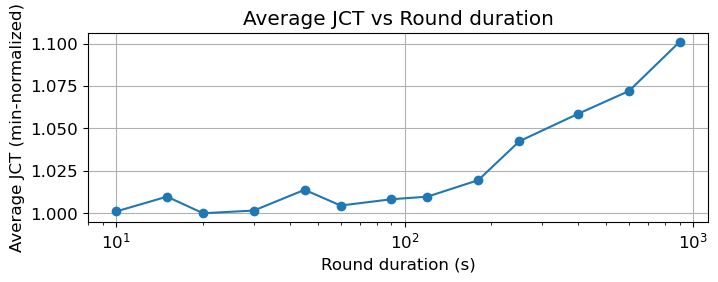

In [12]:
def extract_avg_jct(jcts):
  all_jcts = []
  for _, workload_jcts in jcts.items():
    wjcts = [x['jct'] for x in workload_jcts]
    all_jcts.extend(wjcts)
  return np.mean(all_jcts)

avg_jcts = []
for round_duration in round_durations:
  avg_jcts.append(extract_avg_jct(all_data[round_duration]))

min_jct = min(avg_jcts)
rprint(f"Min JCT: {min_jct}")
# normalize jcts to min value
avg_jcts = [x / min_jct for x in avg_jcts]

# plot avg JCTs vs round duration
plt.plot(round_durations, avg_jcts, marker='o')
plt.xlabel("Round duration (s)")
plt.ylabel("Average JCT (min-normalized)")
plt.title("Average JCT vs Round duration")
standardize(size=(8, 2.5))
plt.xscale('log')
plt.savefig(f"figs/64gpu_avg_jct_vs_round_duration.jpg", bbox_inches='tight', dpi=300)


Min JCT: 6335.304896023954

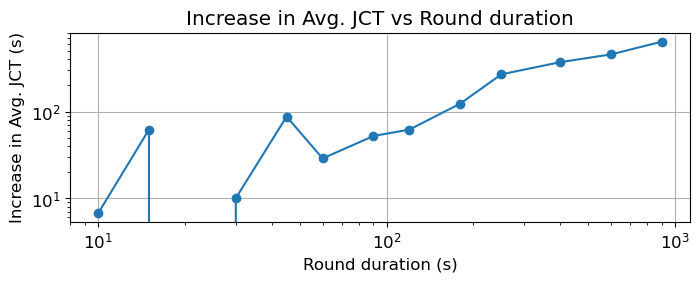

In [13]:
def extract_avg_jct(jcts):
  all_jcts = []
  for _, workload_jcts in jcts.items():
    wjcts = [x['jct'] for x in workload_jcts]
    all_jcts.extend(wjcts)
  return np.mean(all_jcts)

avg_jcts = []
for round_duration in round_durations:
  avg_jcts.append(extract_avg_jct(all_data[round_duration]))

min_jct = min(avg_jcts)
rprint(f"Min JCT: {min_jct}")
# normalize jcts to min value
avg_jcts = [x - min_jct for x in avg_jcts]

# plot avg JCTs vs round duration
plt.plot(round_durations, avg_jcts, marker='o')
plt.xlabel("Round duration (s)")
plt.ylabel("Increase in Avg. JCT (s)")
plt.title("Increase in Avg. JCT vs Round duration")
standardize(size=(8, 2.5))
plt.xscale('log')
plt.yscale('log')
plt.savefig(f"figs/64gpu_increase_avg_jct_vs_round_duration.jpg", bbox_inches='tight', dpi=300)


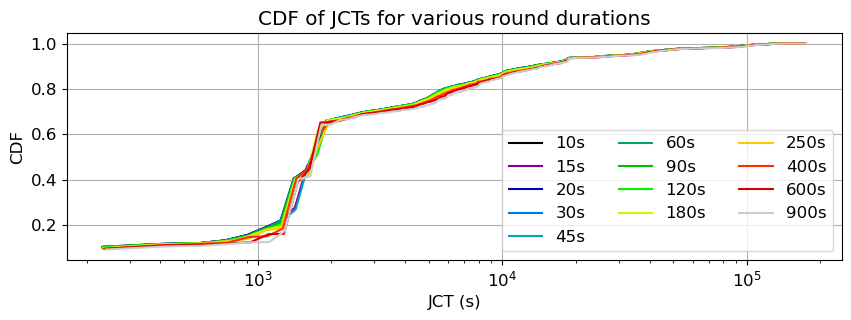

In [14]:
# plot CDFs of JCTs for each round duration
def extract_all_jcts(jcts):
  all_jcts = []
  for _, workload_jcts in jcts.items():
    wjcts = [x['jct'] for x in workload_jcts]
    all_jcts.extend(wjcts)
  return all_jcts

colormap = plt.cm.nipy_spectral
colors = colormap(np.linspace(0, 1, len(round_durations)))
plt.gca().set_prop_cycle('color', colors)

all_jcts = {}
for round_duration in round_durations:
  jcts = extract_all_jcts(all_data[round_duration])
  all_jcts[round_duration] = jcts
  # plot CDF
  hist, bins = np.histogram(jcts, bins=1000)
  cdf = np.cumsum(hist)
  cdf = cdf / cdf[-1]
  plt.plot(bins[1:], cdf, label=f"{round_duration}s")

plt.xlabel("JCT (s)")
plt.ylabel("CDF")
plt.title("CDF of JCTs for various round durations")
standardize(size=(10, 3))
plt.legend(ncol=3, loc='lower right')
plt.xscale('log')
plt.savefig(f"figs/64gpu_jct_cdf_vs_round_duration.jpg", bbox_inches='tight', dpi=300)

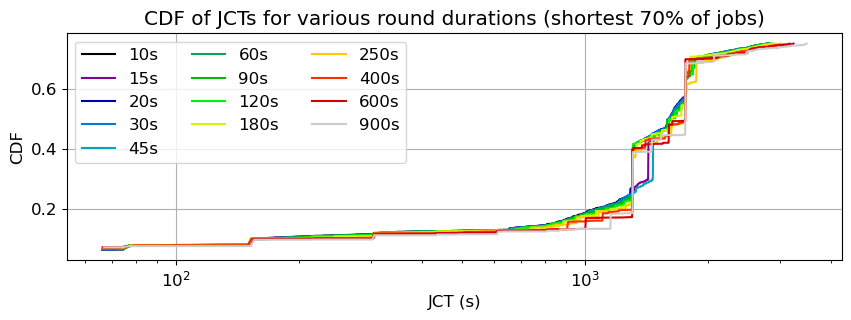

In [15]:
# plot cdf vs round duration shortest 75% of jobs
colormap = plt.cm.nipy_spectral
colors = colormap(np.linspace(0, 1, len(round_durations)))
plt.gca().set_prop_cycle('color', colors)

for round_duration in round_durations:
  jcts = all_jcts[round_duration]
  shortest_70pct = np.percentile(jcts, 70)
  short_jcts = [x for x in jcts if x <= shortest_70pct]
  # plot CDF
  hist, bins = np.histogram(short_jcts, bins=1000)
  cdf = np.cumsum(hist)
  cdf = cdf / cdf[-1]
  cdf = cdf * 0.75
  plt.plot(bins[1:], cdf, label=f"{round_duration}s")

plt.xlabel("JCT (s)")
plt.ylabel("CDF")
plt.title("CDF of JCTs for various round durations (shortest 70% of jobs)")
standardize(size=(10, 3))
plt.legend(ncol=3, loc='upper left')
plt.xscale('log')
plt.savefig(f"figs/64gpu_short70pc_jct_cdf_vs_round_duration.jpg", bbox_inches='tight', dpi=300)

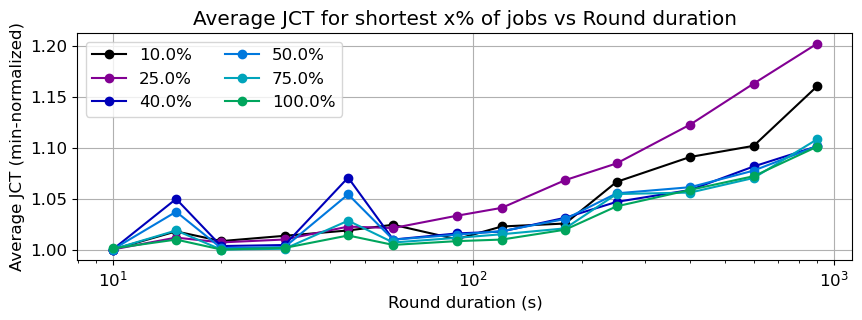

In [16]:
colormap = plt.cm.nipy_spectral
colors = colormap(np.linspace(0, 1, len(round_durations)))
plt.gca().set_prop_cycle('color', colors)

# plot avg JCTs for shortest 25% of jobs
short_thresholds = [0.10, 0.25, 0.40, 0.50, 0.75, 1.00]
for short_threshold in short_thresholds:
  avg_short_jcts = []
  for round_duration in round_durations:
    jcts = all_jcts[round_duration]
    jcts.sort()
    short_jcts = jcts[:int(short_threshold * len(jcts))]
    avg_short_jct = np.mean(short_jcts)
    avg_short_jcts.append(avg_short_jct)
  min_short_jct = min(avg_short_jcts)
  avg_short_jcts = [x / min_short_jct for x in avg_short_jcts]
  plt.plot(round_durations, avg_short_jcts, marker='o', label=f"{short_threshold*100}%")
plt.legend(ncol=2, loc='upper left')
plt.xlabel("Round duration (s)")
plt.ylabel("Average JCT (min-normalized)")
plt.title("Average JCT for shortest x% of jobs vs Round duration")
standardize(size=(10, 3))
plt.xscale('log')
plt.savefig(f"figs/64gpu_avg_short_jct_vs_round_duration.jpg", bbox_inches='tight', dpi=300)

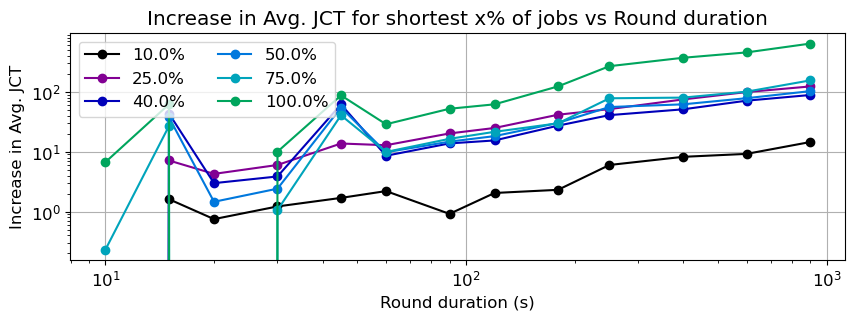

In [19]:
colormap = plt.cm.nipy_spectral
colors = colormap(np.linspace(0, 1, len(round_durations)))
plt.gca().set_prop_cycle('color', colors)

# plot avg JCTs for shortest 25% of jobs
short_thresholds = [0.10, 0.25, 0.40, 0.50, 0.75, 1.00]
for short_threshold in short_thresholds:
  avg_short_jcts = []
  for round_duration in round_durations:
    jcts = all_jcts[round_duration]
    jcts.sort()
    short_jcts = jcts[:int(short_threshold * len(jcts))]
    avg_short_jct = np.mean(short_jcts)
    avg_short_jcts.append(avg_short_jct)
  min_short_jct = min(avg_short_jcts)
  avg_short_jcts = [x - min_short_jct for x in avg_short_jcts]
  plt.plot(round_durations, avg_short_jcts, marker='o', label=f"{short_threshold*100}%")
plt.legend(ncol=2, loc='upper left')
plt.xlabel("Round duration (s)")
plt.ylabel("Increase in Avg. JCT")
plt.title("Increase in Avg. JCT for shortest x% of jobs vs Round duration")
standardize(size=(10, 3))
plt.xscale('log')
plt.yscale('log')
plt.savefig(f"figs/64gpu_increase_avg_short_jct_vs_round_duration.jpg", bbox_inches='tight', dpi=300)